# Часть 2: Исследовательский анализ данных сервиса бронирования билетов Яндекс Афиша в Python и проверка гипотез.

Дата: 30.05.2025

Автор: Ахметдинова Айсылу

### Цель проекта
Цель проекта - провести исследовательский анализ данных сервиса бронирования билетов Яндекс Афиша за период с 1.06.2024 по 31.10.224г, чтобы выяснить причины изменений в пользовательском спросе, определить ключевые факторы, влияющие на популярность мероприятий и проанализировать активность пользователей с разных типов устройств. Также проанализировать сезонные изменения, определить особенности поведения пользователей в зависимости от типа мероприятия, устройств, возрастного ограничения. 

### Задачи проекта

1. Загрузка данных и знакомство с ними
2. Предобработка данных и подготовка их к исследованию
3. Исследовательский анализ данных
4. Статистический анализ данных
5. Общий вывод и рекомендации

### Описание данных

Первый датасет **final_tickets_orders_df.csv** включает информацию обо всех заказах билетов, совершённых с двух типов устройств — мобильных и стационарных

- **order_id** — уникальный идентификатор заказа.
- **user_id** — уникальный идентификатор пользователя.
- **created_dt_msk** — дата создания заказа (московское время).
- **created_ts_msk** — дата и время создания заказа (московское время).
- **event_id** — идентификатор мероприятия из таблицы events.
- **cinema_circuit** — сеть кинотеатров. Если не применимо, то здесь будет значение 'нет'.
- **age_limit** — возрастное ограничение мероприятия.
- **currency_code** — валюта оплаты, например rub для российских рублей.
- **device_type_canonical** — тип устройства, с которого был оформлен заказ, например mobile для мобильных устройств, desktop для стационарных.
- **revenue** — выручка от заказа.
- **service_name** — название билетного оператора.
- **tickets_count** — количество купленных билетов.
- **total** — общая сумма заказа
- **days_since_prev** - количество дней с предыдущей покупки для каждого пользователя. Если покупки не было, то данные содержат пропуск.

Второй датасет **final_tickets_events_df.csv** содержит информацию о событиях, включая город и регион события, а также информацию о площадке проведения мероприятия.

- **event_id** — уникальный идентификатор мероприятия.
- **event_name** — название мероприятия. Аналог поля event_name_code из исходной базы данных.
- **event_type_description** — описание типа мероприятия.
- **event_type_main** — основной тип мероприятия: театральная постановка, концерт и так далее.
- **organizers** — организаторы мероприятия.
- **region_name** — название региона.
- **city_name** — название города.
- **venue_id** — уникальный идентификатор площадки.
- **venue_name** — название площадки.
- **venue_address** — адрес площадки.

Третий датасет **final_tickets_tenge_df.csv** с информацией о курсе тенге к российскому рублю за 2024 год. Значения в рублях представлено для 100 тенге.

- **nominal** — номинал (100 тенге).
- **data** — дата.
- **curs** — курс тенге к рублю.
- **cdx** — обозначение валюты (kzt).

## 1. Загрузка данных и знакомство с ними
Загрузим данные и получим первую информацию о них. Оценим объём данных, их корректность и соответствие описанию.

In [1]:
# Импортируем библиотеки
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import seaborn as sns


In [2]:
# Загрузим датасеты и посмотрим первые 5 строк
orders_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_orders_df.csv')
events_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_events_df.csv')
tenge_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')
display(orders_df.head())
display(events_df.head())
display(tenge_df.head())

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"


,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [3]:
# Выведем общую информацию о таблицах
display(orders_df.info())
display(events_df.info())
display(tenge_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               290849 non-null  int64  
 1   user_id                290849 non-null  object 
 2   created_dt_msk         290849 non-null  object 
 3   created_ts_msk         290849 non-null  object 
 4   event_id               290849 non-null  int64  
 5   cinema_circuit         290849 non-null  object 
 6   age_limit              290849 non-null  int64  
 7   currency_code          290849 non-null  object 
 8   device_type_canonical  290849 non-null  object 
 9   revenue                290849 non-null  float64
 10  service_name           290849 non-null  object 
 11  tickets_count          290849 non-null  int64  
 12  total                  290849 non-null  float64
 13  days_since_prev        268909 non-null  float64
dtypes: float64(3), int64(4), object(7)
m

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22427 entries, 0 to 22426
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   event_id                22427 non-null  int64 
 1   event_name              22427 non-null  object
 2   event_type_description  22427 non-null  object
 3   event_type_main         22427 non-null  object
 4   organizers              22427 non-null  object
 5   region_name             22427 non-null  object
 6   city_name               22427 non-null  object
 7   city_id                 22427 non-null  int64 
 8   venue_id                22427 non-null  int64 
 9   venue_name              22427 non-null  object
 10  venue_address           22427 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.9+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


None

В таблице с информацией о заказах orders_df представлены данные в 290849 строк и 14 столбцов. Названия столбцов в едином регистре, без лишних пробелов. Только в одном столбце days_since_prev есть пропуски и это нормально, они означают, что у этого покупателя не было покупок. В двух столбцах created_dt_msk и created_ts_msk не соответствут тип данных, нужно будет привести к типу даты.

В таблице с информацией о событиях events_df представлены данные в 22427 строк и 11 столбцов. Названия столбцов в едином регистре, без лишних пробелов. Пропуски в данных отсутствуют, типы данных соответствуют описанию.

В таблице с информацией о курсе тенге к рублю tenge_df представлены данные в 357 строк и 4 столбцов. Названия столбцов в едином регистре, без лишних пробелов. Пропуски в данных отсутствуют, тип данных в столбце с датой нужно будет перевести к временному.

## 2. Предобработка данных и подготовка их к исследованию


In [4]:
# Приведем столбцы с датой и временем к соответствующему типу
orders_df['created_dt_msk'] = pd.to_datetime(orders_df['created_dt_msk'])
orders_df['created_ts_msk'] = pd.to_datetime(orders_df['created_ts_msk'])
tenge_df ['data'] = pd.to_datetime(tenge_df['data'])

In [5]:
# Объединим данные о заказах и событиях в один датафрейм
df_merged = pd.merge(orders_df, events_df, on='event_id', how='inner')
df_merged.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6"
1,7431164,024dc5236465850,2024-07-23,2024-07-23 20:52:02,169230,нет,16,rub,mobile,1902.42,...,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6"
2,7431106,024dc5236465850,2024-07-23,2024-07-23 20:54:19,169230,нет,16,rub,mobile,1141.45,...,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6"
3,7431135,024dc5236465850,2024-07-23,2024-07-23 20:59:44,169230,нет,16,rub,mobile,1902.42,...,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6"
4,7431048,024dc5236465850,2024-07-23,2024-07-23 21:02:08,169230,нет,16,rub,mobile,1521.94,...,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6"


In [6]:
# Изучим категориальные данные
categorical_cols = ['cinema_circuit', 'currency_code', 'device_type_canonical', 
                    'service_name', 'event_type_description', 'event_type_main',
                    'region_name', 'city_name', 'venue_name']

for col in categorical_cols:
    display(f'Столбец: {col}')
    display(df_merged[col].value_counts(dropna=False)) 
    display('-'*60)

'Столбец: cinema_circuit'

нет           289213
Другое          1261
КиноСити         122
Москино            7
Киномакс           7
ЦентрФильм         1
Name: cinema_circuit, dtype: int64

'------------------------------------------------------------'

'Столбец: currency_code'

rub    285542
kzt      5069
Name: currency_code, dtype: int64

'------------------------------------------------------------'

'Столбец: device_type_canonical'

mobile     232490
desktop     58121
Name: device_type_canonical, dtype: int64

'------------------------------------------------------------'

'Столбец: service_name'

Билеты без проблем        63519
Лови билет!               41124
Билеты в руки             40343
Мой билет                 34839
Облачко                   26642
Лучшие билеты             17774
Весь в билетах            16849
Прачечная                 10273
Край билетов               6207
Тебе билет!                5228
Яблоко                     5039
Дом культуры               4502
За билетом!                2865
Городской дом культуры     2733
Show_ticket                2200
Мир касс                   2167
Быстробилет                2003
Выступления.ру             1616
Восьмёрка                  1118
Crazy ticket!               790
Росбилет                    539
Шоу начинается!             499
Быстрый кассир              381
Радио ticket                376
Телебилет                   321
КарандашРУ                  133
Реестр                      125
Билет по телефону            85
Вперёд!                      80
Дырокол                      74
Кино билет                   67
Цвет и б

'------------------------------------------------------------'

'Столбец: event_type_description'

концерт                   112049
событие                    58605
спектакль                  50592
шоу                        13626
спорт                      12837
мюзикл                      9919
спортивное мероприятие      9074
балет                       5998
выставка                    5876
цирковое шоу                5327
фестиваль                   4273
опера                       1314
ёлка                         945
музыкальный спектакль        140
кукольный спектакль           13
экскурсия                      8
оперетта                       7
подарок                        4
снегурочка                     3
рок-мюзикл                     1
Name: event_type_description, dtype: int64

'------------------------------------------------------------'

'Столбец: event_type_main'

концерты    115276
театр        67321
другое       65867
спорт        21911
стендап      13393
выставки      4854
ёлки          1989
Name: event_type_main, dtype: int64

'------------------------------------------------------------'

'Столбец: region_name'

Каменевский регион          91058
Североярская область        44049
Широковская область         16457
Медовская область           13901
Озернинский край            10476
                            ...  
Лесноярский край               19
Крутоводский регион            18
Верхозёрский край              11
Сосноводолинская область       10
Теплоозёрский округ             7
Name: region_name, Length: 81, dtype: int64

'------------------------------------------------------------'

'Столбец: city_name'

Глиногорск       89446
Озёрск           43910
Радужсвет        13711
Радужнополье      8741
Верховино         6579
                 ...  
Верхозорье           1
Поляноречинск        1
Сосновогорск         1
Берёзовка            1
Полянск              1
Name: city_name, Length: 352, dtype: int64

'------------------------------------------------------------'

'Столбец: venue_name'

Студия дизайна "Платформа" Инкорпорэйтед         9910
Картинная галерея "Светлячок" Лтд                4406
Креативное пространство "Вдох" Лимитед           4257
Центр культурного наследия "Заряд" и партнеры    4099
Студия дизайна "Лестница" Лимитед                4025
                                                 ... 
Исторический центр "Ремесло" Инк                    1
Дом культуры "Образ" Лимитед                        1
Народный театр "Ремесло" Лимитед                    1
Музей "Магнит" Групп                                1
Театр для детей "Эпоха" и партнеры                  1
Name: venue_name, Length: 3217, dtype: int64

'------------------------------------------------------------'

In [7]:
# Проверим датафрейм на пропуски и обозначения отсутствия данных
# Список значений
check_values = ['na', 'null', 'none', 'unknown']

# Приведём все значения датафрейма к строковому типу и к нижнему регистру для корректного поиска
df_merged_str = df_merged.astype(str).apply(lambda x: x.str.lower())

# Создадим маску для каждого значения и суммируем по всем столбцам
mask = pd.DataFrame(False, index=df_merged.index, columns=df_merged.columns)
for val in check_values:
    mask = mask | (df_merged_str == val)

# Проверим, есть ли такие значения в датафрейме
has_values = mask.any().any()

display(f'В датафрейме встречаются строки из списка {check_values}: {has_values}')

"В датафрейме встречаются строки из списка ['na', 'null', 'none', 'unknown']: False"

В категориальных данных нет никаких ненормальностей, названия категорий в едином стиле, без лишних пробелов. Пропуски и обозначения данных на отсутствие данных не обнаружили.

In [8]:
# Отделяем данные по валютам с созданием копий
df_rub = df_merged[df_merged['currency_code'] == 'rub'].copy()
df_kzt = df_merged[df_merged['currency_code'] == 'kzt'].copy()

In [9]:
display("Статистика по рублям (rub):")
display(df_rub[['revenue', 'tickets_count']].describe())

display("Статистика по тенге (kzt):")
display(df_kzt[['revenue', 'tickets_count']].describe())

'Статистика по рублям (rub):'

,revenue,tickets_count
count,285542.000000,285542.000000
mean,548.013929,2.754159
std,871.750181,1.171575
min,-90.760000,1.000000
25%,114.170000,2.000000
50%,346.630000,3.000000
75%,793.320000,4.000000
max,81174.540000,57.000000


'Статистика по тенге (kzt):'

,revenue,tickets_count
count,5069.000000,5069.000000
mean,4995.206767,2.762872
std,4916.752776,1.115558
min,0.000000,1.000000
25%,518.100000,2.000000
50%,3698.830000,3.000000
75%,7397.660000,4.000000
max,26425.860000,6.000000


Что мы видим: 
- Средняя выручка — около 548 рублей, но стандартное отклонение очень большое (871.75), что говорит о высокой вариативности и вероятных выбросах.  
- Среднее количество билетов — около 2.75, стандартное отклонение 1.17 — относительно небольшая вариативность.
- Минимальная выручка: -90.76 рублей — отрицательное значение выручки. Возможно, ошибка в данных или возврат/отмена заказа.  
- Минимальное количество билетов: минимум — 1, что логично, ведь минимум билетов — это хотя бы один билет. 
- 75% заказов имеют выручку до 793.32 руб. Это говорит о скошенном распределении в сторону больших значений 
- Максимальная ыручка: 81 174.54 руб. — очень большое значение, скорее всего выброс.  
- Максимальное количество билетов: 57 — тоже достаточно большое количество билетов в одном заказе, но может быть реалистично для групповых заказов.

Для наглядности построим графики.

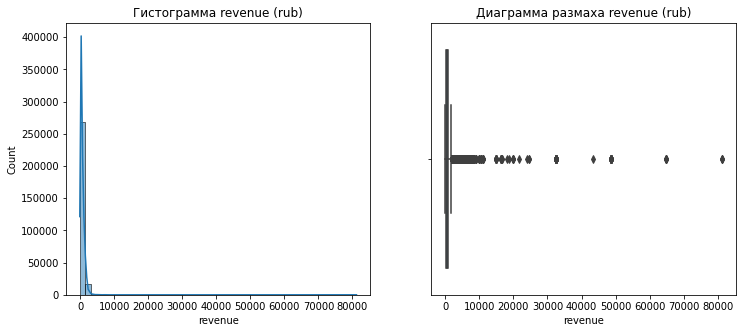

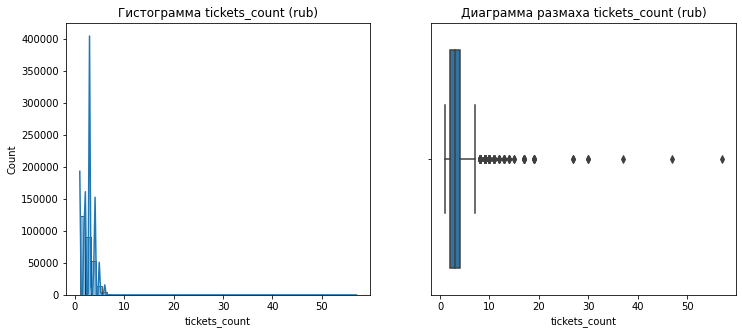

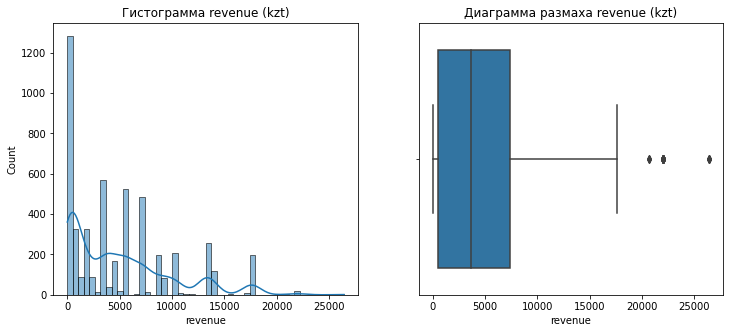

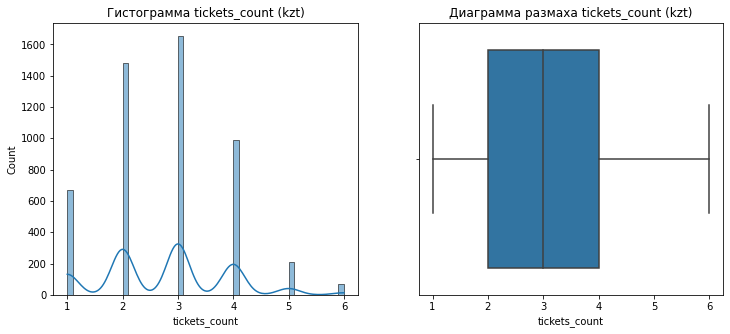

In [10]:
# Функция для построения графиков
def plot_distribution(data, column, currency):
    plt.figure(figsize=(12,5))

    plt.subplot(1, 2, 1)
    sns.histplot(data[column], bins=50, kde=True)
    plt.title(f'Гистограмма {column} ({currency})')

    plt.subplot(1, 2, 2)
    sns.boxplot(x=data[column])
    plt.title(f'Диаграмма размаха {column} ({currency})')

    plt.show()

# Для rub
plot_distribution(df_rub, 'revenue', 'rub')
plot_distribution(df_rub, 'tickets_count', 'rub')

# Для kzt
plot_distribution(df_kzt, 'revenue', 'kzt')
plot_distribution(df_kzt, 'tickets_count', 'kzt')

По графикам убедились, что присутствуют выбросы во всех валютах. По количеству билетов ситуация не критичная. Далее отберем значения по 99-му процентилю.

'99-й процентиль revenue в rub: 2570.8'

'99-й процентиль revenue в kzt: 17617.24'

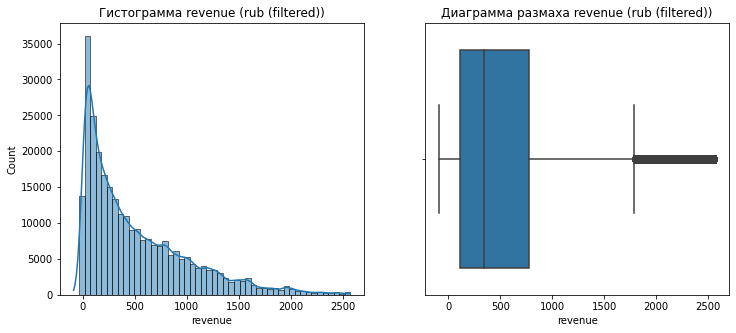

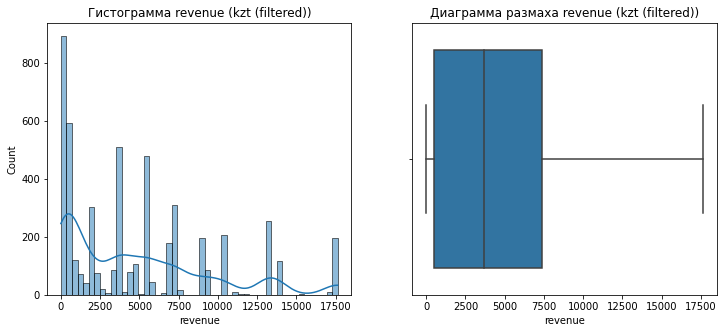

In [11]:
# Находим 99-й процентиль для рубля и тенге
revenue_99_rub = df_rub['revenue'].quantile(0.99)
revenue_99_kzt = df_kzt['revenue'].quantile(0.99)

display(f'99-й процентиль revenue в rub: {revenue_99_rub}')
display(f'99-й процентиль revenue в kzt: {revenue_99_kzt}')

# Фильтруем данные по этому порогу
df_rub_filtered = df_rub[df_rub['revenue'] <= revenue_99_rub]
df_kzt_filtered = df_kzt[df_kzt['revenue'] <= revenue_99_kzt]

# Проверяем после фильтрации
plot_distribution(df_rub_filtered, 'revenue', 'rub (filtered)')
plot_distribution(df_kzt_filtered, 'revenue', 'kzt (filtered)')


После фильтрации по 99-му процентилю важно оценить, сколько данных мы потеряли, чтобы понять, насколько сильно срезали хвост распределения и как это может повлиять на дальнейший анализ.

In [12]:
# Оценим потери
# Для рублёвых данных
total_rub = len(df_rub)
filtered_rub = len(df_rub_filtered)
lost_rub = total_rub - filtered_rub
lost_rub_ratio = lost_rub / total_rub * 100

display(f'Рубль: всего строк {total_rub}, после фильтрации {filtered_rub}, потеряно {lost_rub} ({lost_rub_ratio:.2f}%)')

# Для тенге
total_kzt = len(df_kzt)
filtered_kzt = len(df_kzt_filtered)
lost_kzt = total_kzt - filtered_kzt
lost_kzt_ratio = lost_kzt / total_kzt * 100

display(f'Тенге: всего строк {total_kzt}, после фильтрации {filtered_kzt}, потеряно {lost_kzt} ({lost_kzt_ratio:.2f}%)')


'Рубль: всего строк 285542, после фильтрации 282742, потеряно 2800 (0.98%)'

'Тенге: всего строк 5069, после фильтрации 5040, потеряно 29 (0.57%)'

Для обеих валют мы потеряли менее 1% данных, это некритично и не повлияет на дальнейший анализ.
Проверим данные на наличие явных и неявных дубликатов.

In [13]:
# Обьединим датафреймы обратно и посчитаем количество строк
df_full = pd.concat([df_rub_filtered, df_kzt_filtered], ignore_index=True)
display(f'Общее количество строк: {df_full.shape[0]}')

'Общее количество строк: 287782'

In [14]:
# Количество явных дубликатов
num_duplicates = df_full.duplicated().sum()
display(f'Явных дубликатов: {num_duplicates}')


'Явных дубликатов: 0'

In [15]:
# Выбираем столбцы, по которым считаем дубликатами (без order_id)
cols_for_dup = ['user_id', 'created_dt_msk', 'created_ts_msk', 'event_id',
       'cinema_circuit', 'age_limit', 'currency_code', 'device_type_canonical',
       'revenue', 'service_name', 'tickets_count', 'total', 'days_since_prev',
       'event_name', 'event_type_description', 'event_type_main', 'organizers',
       'region_name', 'city_name', 'city_id', 'venue_id', 'venue_name',
       'venue_address']

dup_mask = df_full.duplicated(subset=cols_for_dup) 

display(f'Количество неявных дубликатов по выбранным столбцам: {dup_mask.sum()}')



'Количество неявных дубликатов по выбранным столбцам: 30'

In [16]:
# Количество дубликатов
num_duplicates = dup_mask.sum()

# Общее количество строк в датафрейме
total_rows = len(df_full)

# Доля дубликатов (в виде числа от 0 до 1)
dup_ratio = num_duplicates / total_rows

# Или в процентах
dup_percent = dup_ratio * 100

display(f'Количество неявных дубликатов по выбранным столбцам: {num_duplicates}')
display(f'Доля дубликатов: {dup_ratio:.4f} ({dup_percent:.2f}%)')

'Количество неявных дубликатов по выбранным столбцам: 30'

'Доля дубликатов: 0.0001 (0.01%)'

In [17]:
# Удаляем дубликаты из DataFrame по выбранным столбцам
df_cleaned = df_full.drop_duplicates(subset=cols_for_dup)

display(f'Количество строк после очистки от дубликатов: {df_cleaned.shape[0]}')

'Количество строк после очистки от дубликатов: 287752'

Явные дубликаты в данных отсутствуют. Неявные дубликаты обнаружены в количестве 31 шт и удалены, так как занимают всего 0.01%  от общих данных. Количество строк до обработки 287782, после очистки от дубликатов составило 287751.

Далее создаем несколько новых столбцов:
- revenue_rub — приведем выручку с заказа к единой валюте — российскому рублю. Для этого используем датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю tenge_df за 2024 год.
- one_ticket_revenue_rub — рассчитаем выручку с продажи одного билета на мероприятие.
- month — выделим месяц оформления заказа в отдельный столбец.
- season — создаем столбец с информацией о сезонности, включая такие категории, как: 'лето', 'осень', 'зима', 'весна'.

In [18]:
# Объединяем датафрейм
df = df_cleaned.merge(tenge_df, left_on='created_dt_msk', right_on='data', how='left')

# Изначально присваиваем выручку
df['revenue_rub'] = df['revenue']

# Пересчитываем выручку для тенге
df.loc[df['currency_code'] == 'kzt', 'revenue_rub'] = (
    df['revenue'] * df['curs'] / df['nominal']
)
# Округляем значения в столбце revenue_rub до двух знаков после запятой
df['revenue_rub'] = df['revenue_rub'].round(2)
df.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,city_name,city_id,venue_id,venue_name,venue_address,data,nominal,curs,cdx,revenue_rub
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,Глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",2024-08-20,100,18.6972,kzt,1521.94
1,7431164,024dc5236465850,2024-07-23,2024-07-23 20:52:02,169230,нет,16,rub,mobile,1902.42,...,Глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",2024-07-23,100,18.3419,kzt,1902.42
2,7431106,024dc5236465850,2024-07-23,2024-07-23 20:54:19,169230,нет,16,rub,mobile,1141.45,...,Глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",2024-07-23,100,18.3419,kzt,1141.45
3,7431135,024dc5236465850,2024-07-23,2024-07-23 20:59:44,169230,нет,16,rub,mobile,1902.42,...,Глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",2024-07-23,100,18.3419,kzt,1902.42
4,7431048,024dc5236465850,2024-07-23,2024-07-23 21:02:08,169230,нет,16,rub,mobile,1521.94,...,Глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",2024-07-23,100,18.3419,kzt,1521.94


In [19]:
# Рассчитаем выручку с продажи одного билета на мероприятие
df['one_ticket_revenue_rub'] = df['revenue_rub'] / df['tickets_count']
df['one_ticket_revenue_rub'] = df['one_ticket_revenue_rub'].round(2)

In [20]:
# Выделяем месяц оформления заказа
df['month'] = pd.to_datetime(df['created_dt_msk']).dt.month

In [21]:
# Создадим функцию для присвоения сезона
def get_season(month):
    if month in [6, 7, 8]:
        return 'лето'
    elif month in [9, 10, 11]:
        return 'осень'
    else:
        return None

df['season'] = df['month'].apply(get_season)

In [22]:
# Убедимся, что категории присвоены корректно.
df['season'].unique()

array(['лето', 'осень'], dtype=object)

In [23]:
df.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,venue_name,venue_address,data,nominal,curs,cdx,revenue_rub,one_ticket_revenue_rub,month,season
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",2024-08-20,100,18.6972,kzt,1521.94,380.48,8,лето
1,7431164,024dc5236465850,2024-07-23,2024-07-23 20:52:02,169230,нет,16,rub,mobile,1902.42,...,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",2024-07-23,100,18.3419,kzt,1902.42,380.48,7,лето
2,7431106,024dc5236465850,2024-07-23,2024-07-23 20:54:19,169230,нет,16,rub,mobile,1141.45,...,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",2024-07-23,100,18.3419,kzt,1141.45,380.48,7,лето
3,7431135,024dc5236465850,2024-07-23,2024-07-23 20:59:44,169230,нет,16,rub,mobile,1902.42,...,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",2024-07-23,100,18.3419,kzt,1902.42,380.48,7,лето
4,7431048,024dc5236465850,2024-07-23,2024-07-23 21:02:08,169230,нет,16,rub,mobile,1521.94,...,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",2024-07-23,100,18.3419,kzt,1521.94,380.48,7,лето


Предобработка данных закончена. 
- Проверили данные на пропуски. Проверили, что выгрузка данных из SQL была успешной. Кроме столбца days_since_prev, данные не содержат пропусков.
- Изучили значения в ключевых столбцах и не обнаружили ошибок.
- Для категориальных значений изучили, какие категории присутствуют в данных. 
- Для количественных значений посмотрели на распределение и наличие выбросов. Отобрали значения по 99-му процентилю. Для обеих валют мы потеряли менее 1% дааных, это некритично и не повлияет на дальнейший анализ.
- Проверили явные и неявные дубликаты. Явных не обнаружили, удалили 31 неявных.
- Провели преобразования типов данных в столбцах с датой и временем.
- Создали несколько новых столбцов:
  - revenue_rub — выручка с заказов в единой валюте (руб).
  - one_ticket_revenue_rub — выручка с продажи одного билета на мероприятие.
  - month — месяц оформления заказа.
  - season — информация о сезонности (лето,осень).

 ##  Исследовательский анализ данных

### Анализ распределения заказов по сегментам и их сезонные изменения

- Для каждого месяца найдем количество заказов и визуализируем результаты. Проверим, фиксируется ли увеличение заказов от июня к ноябрю 2024 года.

In [24]:
# Подсчёт количества заказов по месяцам
orders_per_month = df.groupby('month')['order_id'].nunique().reset_index()

# Переименуем столбцы для удобства
orders_per_month.columns = ['month', 'order_count']

display(orders_per_month)

,month,order_count
0,6,34164
1,7,40407
2,8,44550
3,9,69352
4,10,99279


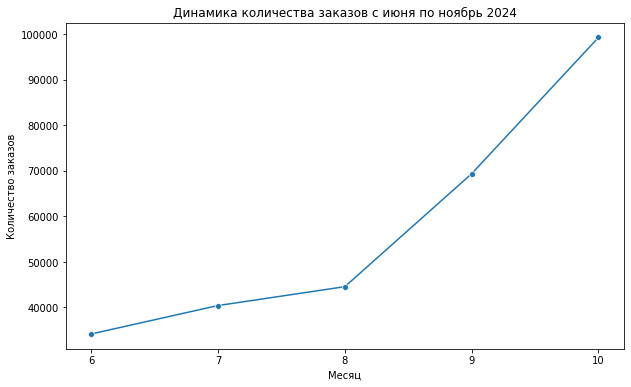

In [25]:
plt.figure(figsize=(10,6))
sns.lineplot(data=orders_per_month, x='month', y='order_count', marker='o')

plt.title('Динамика количества заказов с июня по ноябрь 2024')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.xticks(ticks=orders_per_month['month'], labels=orders_per_month['month'])

plt.show()

И по графику и по таблице убедились, что действительно наблюдается рост заказов к осени почти в 3 раза. Значит, сезонность имеет место быть.

- Для осеннего и летнего периодов сравним распределение заказов билетов по разным категориям: тип мероприятия, тип устройства, категория мероприятия по возрастному рейтингу. Результаты визуализируем подходящим графиком, который поможет сопоставить значения для летнего и осеннего сезонов.

In [26]:
# Создадим функцию, которая для заданного столбца считает доли заказов в каждом сезоне
def get_relative_distribution(df, category_col):
    # Считаем количество заказов по сезону и категории
    counts = df.groupby(['season', category_col])['order_id'].count().reset_index()
    counts.rename(columns={'order_id': 'count'}, inplace=True)
    
    # Считаем общее количество заказов в сезоне
    total_per_season = counts.groupby('season')['count'].transform('sum')
    
    # Считаем долю
    counts['share'] = counts['count'] / total_per_season
    
    return counts

In [27]:
# Получим распределение для нужных категорий
dist_event_type = get_relative_distribution(df, 'event_type_main')
dist_device_type = get_relative_distribution(df, 'device_type_canonical')
dist_age_limit = get_relative_distribution(df, 'age_limit')

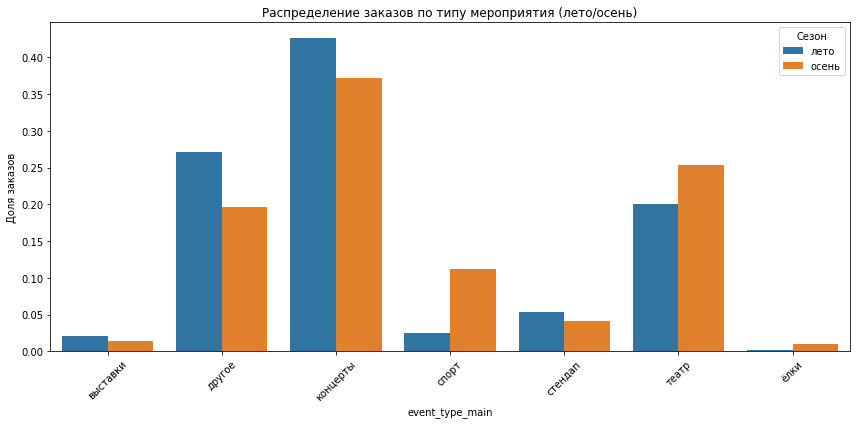

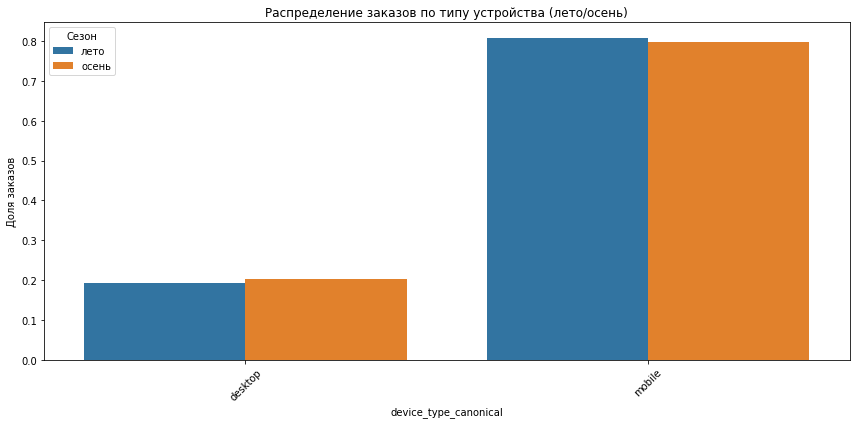

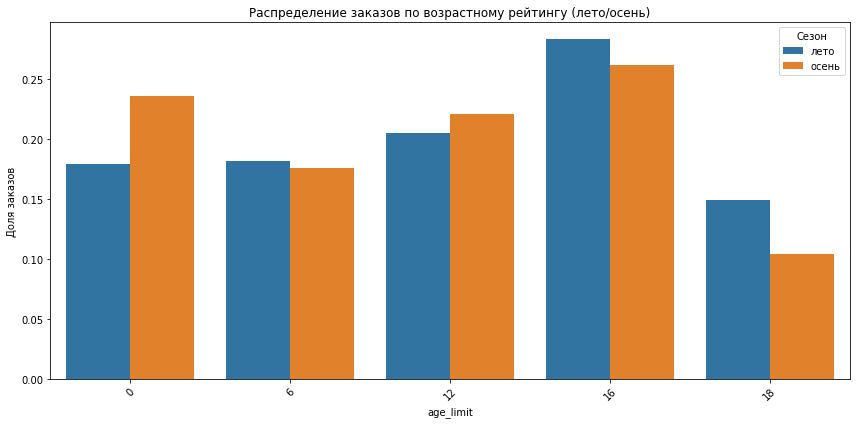

In [28]:
# Для сравнения долей по двум сезонам удобно использовать группированные столбчатые диаграммы
def plot_comparison(data, category_col, title):
    plt.figure(figsize=(12,6))
    sns.barplot(data=data, x=category_col, y='share', hue='season')
    plt.title(title)
    plt.ylabel('Доля заказов')
    plt.xlabel(category_col)
    plt.xticks(rotation=45)
    plt.legend(title='Сезон')
    plt.tight_layout()
    plt.show()

plot_comparison(dist_event_type, 'event_type_main', 'Распределение заказов по типу мероприятия (лето/осень)')
plot_comparison(dist_device_type, 'device_type_canonical', 'Распределение заказов по типу устройства (лето/осень)')
plot_comparison(dist_age_limit, 'age_limit', 'Распределение заказов по возрастному рейтингу (лето/осень)')


Летом концерты чаще посещают, чем осенью. Категория другое тоже лидирует летом. А вот к осени более популярно посещать театры и спортивные мероприятия. Все это обьясняется тем, что на летнее время театры уходят в отпуска, поэтому важно заполнить данный пробел и развивать в этот период концертную деятельность и другое. К осени мы наблюдали рост активности пользователей, поэтому большую прибыль мы можем получить именно в данный сезон и стоит акцентировать внимание на театры, спортивные мероприятия, елки.

По распределению заказов по типам устройств можно сказать, что сильного различия нет. Мобильные устройства лидируют и летом и осенью, летом чуть больше, т к многие в отпусках и больше времени проводят вне помещений, где могут быть использованы стационарные устройства. А вот осенью наоборот,больше заказов со стационарных устройств, т к больше времени проводят на работе, в помещениях.

Самый популярный возраст, который посещают мероприятия это 16+, 12+ и 0+. В летний период более активны 16+, 12+,6+. Думаю, что это связано с наступлением каникул. А осенью лидируют 16+,0+,12+. Думаю, это также связано с наступлением учебного сезона, где активируются театральные постановки, спортивные мероприятия, предновогодние утренники.

- Далее изучим изменение выручки с продажи одного билета в зависимости от типа мероприятия летом и осенью. 

In [29]:
# Расcчитаем среднюю выручку с одного билета по типу мероприятия и сезону
# Группируем по season и event_type_main, считаем среднее
mean_revenue = df.groupby(['event_type_main', 'season'])['one_ticket_revenue_rub'].mean().reset_index()
mean_revenue.rename(columns={'one_ticket_revenue_rub': 'mean_ticket_revenue'}, inplace=True)   

In [30]:
# Преобразуем данные для удобства сравнения
pivot_revenue = mean_revenue.pivot(index='event_type_main', columns='season', values='mean_ticket_revenue').reset_index()
pivot_revenue.columns.name = None  # убираем имя столбцов для удобства

In [31]:
# Изменения в относительном значении
pivot_revenue['relative_change_%'] = ((pivot_revenue['осень'] - pivot_revenue['лето']) / pivot_revenue['лето']) * 100

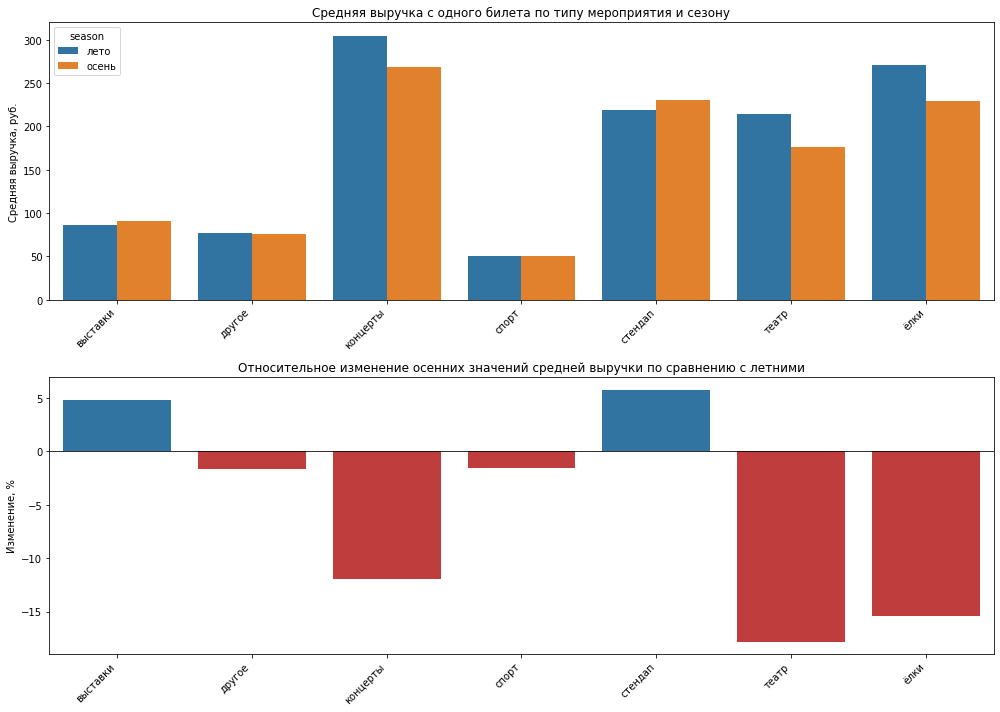

In [32]:
# Построим графики
plt.figure(figsize=(14, 10))

# График средних значений
plt.subplot(2, 1, 1)
mean_melted = mean_revenue.copy()
sns.barplot(data=mean_melted, x='event_type_main', y='mean_ticket_revenue', hue='season')
plt.title('Средняя выручка с одного билета по типу мероприятия и сезону')
plt.ylabel('Средняя выручка, руб.')
plt.xlabel('')
plt.xticks(rotation=45, ha='right')

# График относительного изменения
plt.subplot(2, 1, 2)
# Создаем список цветов: синий для положительных, красный для отрицательных значений
colors = ['tab:blue' if x >= 0 else 'tab:red' for x in pivot_revenue['relative_change_%']]
sns.barplot(data=pivot_revenue, x='event_type_main', y='relative_change_%', palette=colors)
plt.axhline(0, color='black', linewidth=0.8)
plt.title('Относительное изменение осенних значений средней выручки по сравнению с летними')
plt.ylabel('Изменение, %')
plt.xlabel('')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

На графиках наглядно видим относительное изменение осенних значений по сравнению с летними. Средняя выручка с одного билета по выставкам и стендапам выросла примерно на 5%, по категории спорт и другое снизилась на 2%, концерты, елки и театры подешевели  более 10%.  

### Осенняя активность пользователей

- Проанализируем динамику изменений по дням для:
  - общего числа заказов;
  - количества активных пользователей DAU;
  - среднего числа заказов на одного пользователя;
  - средней стоимости одного билета.

In [33]:
# Отфильтруем данные за осень
df_autumn = df[df['season'] == 'осень'].copy()

In [34]:
# Группируем данные по дате
daily_stats = df_autumn.groupby('created_dt_msk').agg(
    total_orders = ('order_id', 'count'),          # общее число заказов
    unique_users = ('user_id', 'nunique'),         # число уникальных пользователей (DAU)
    avg_ticket_price = ('one_ticket_revenue_rub', 'mean')    # средняя стоимость билета
).reset_index()

# Рассчитаем среднее число заказов на одного пользователя
daily_stats['orders_per_user'] = daily_stats['total_orders'] / daily_stats['unique_users']

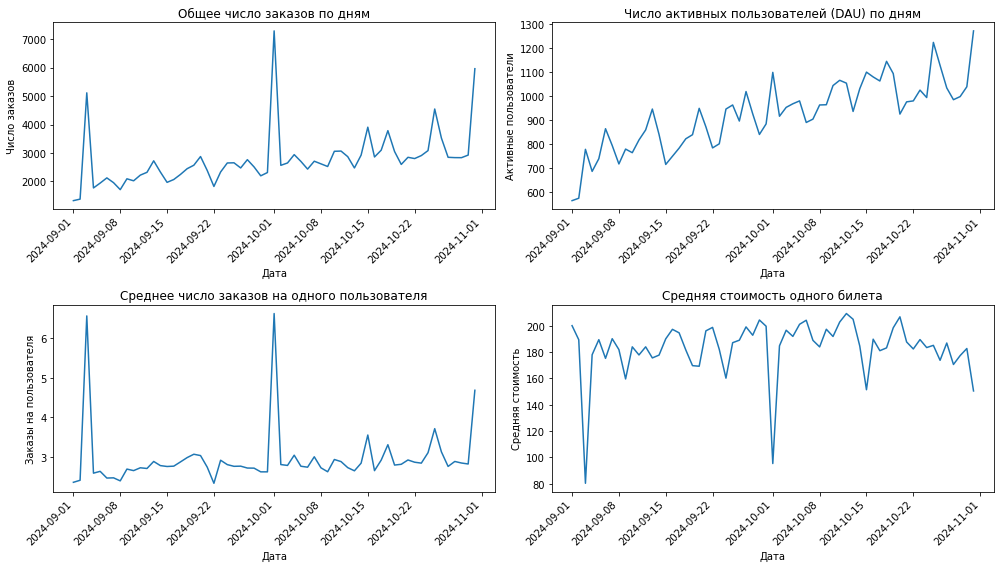

In [35]:
# Визуализация динамики по дням
plt.figure(figsize=(14, 8))

# График общего числа заказов
plt.subplot(2, 2, 1)
sns.lineplot(data=daily_stats, x='created_dt_msk', y='total_orders')
plt.title('Общее число заказов по дням')
plt.xlabel('Дата')
plt.ylabel('Число заказов')
plt.xticks(rotation=45, ha='right')

# График DAU
plt.subplot(2, 2, 2)
sns.lineplot(data=daily_stats, x='created_dt_msk', y='unique_users')
plt.title('Число активных пользователей (DAU) по дням')
plt.xlabel('Дата')
plt.ylabel('Активные пользователи')
plt.xticks(rotation=45, ha='right')

# График среднего числа заказов на пользователя
plt.subplot(2, 2, 3)
sns.lineplot(data=daily_stats, x='created_dt_msk', y='orders_per_user')
plt.title('Среднее число заказов на одного пользователя')
plt.xlabel('Дата')
plt.ylabel('Заказы на пользователя')
plt.xticks(rotation=45, ha='right')

# График средней стоимости билета
plt.subplot(2, 2, 4)
sns.lineplot(data=daily_stats, x='created_dt_msk', y='avg_ticket_price')
plt.title('Средняя стоимость одного билета')
plt.xlabel('Дата')
plt.ylabel('Средняя стоимость')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [36]:
# Анализ недельной цикличности
# Добавим столбец с днем недели (0 — понедельник, 6 — воскресенье)
daily_stats['weekday'] = daily_stats['created_dt_msk'].dt.dayofweek

# Добавим признак выходного дня (суббота и воскресенье)
daily_stats['is_weekend'] = daily_stats['weekday'].isin([5, 6])

# Сравнение активности в будни и выходные
# Средние значения по каждому дню недели
weekday_stats = daily_stats.groupby('weekday').agg({
    'total_orders': 'mean',
    'unique_users': 'mean',
    'orders_per_user': 'mean',
    'avg_ticket_price': 'mean'
}).reset_index()



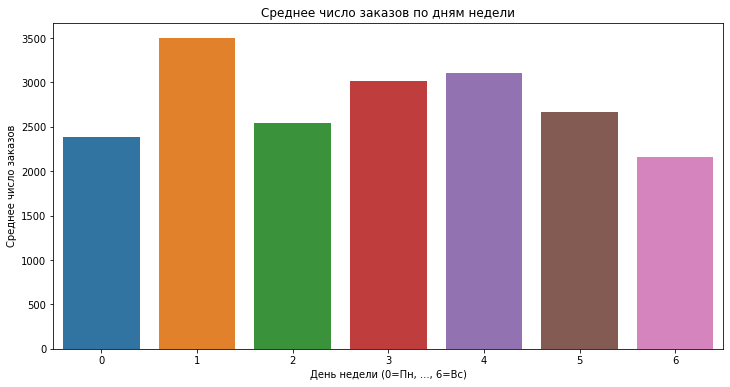

In [37]:
# График активности по дням недели
plt.figure(figsize=(12, 6))
sns.barplot(data=weekday_stats, x='weekday', y='total_orders')
plt.title('Среднее число заказов по дням недели')
plt.xlabel('День недели (0=Пн, ..., 6=Вс)')
plt.ylabel('Среднее число заказов')
plt.show()



Число заказов по дням имеет положительную динамику, наблюдаются пики 1.09.2024 и 1.10.2024, видимо связанные с праздничным днем. 

Число активных пользователей также показывает рост.
Среднее число заказов на пользователя стабильна, за исключением также  1.09.2024 и 1.10.2024, предполагаем, что из-за праздников.

Средняя стоимость одного билета также более-менее стабильна, к концу осени наблюдается спад. Также видим резкое снижение  1.09.2024 и 1.10.2024, возможно из-за праздников проводились различные акции, что удешевило стоимость билета.

По дням недели среднее количество заказов распределяется более-менее стабильно, резких скачков не наблюдается. Во вторник видим увеличение заказов, в воскресенье и понедельник меньше заказов, чем в другие дни недели.

### Популярные события и партнёры

- Для каждого региона посчитаем уникальное количество мероприятий и общее число заказов и выведем топ-10 регионов по количеству проведенных уникальных мероприятий.

In [38]:
# Анализ по регионам
region_stats = df.groupby('region_name').agg(
    unique_events=('event_id', 'nunique'),
    total_orders=('order_id', 'count')
).reset_index()

# Общие значения для подсчёта долей
total_unique_events = df['event_id'].nunique()
total_orders = df['order_id'].count()

# Добавляем доли
region_stats['events_share'] = region_stats['unique_events'] / total_unique_events
region_stats['orders_share'] = region_stats['total_orders'] / total_orders

# Сортируем по количеству уникальных мероприятий, чтобы увидеть регионы с наибольшим разнообразием
region_stats = region_stats.sort_values(by='unique_events', ascending=False)

display('Топ-10 регионов по количеству уникальных мероприятий:')
display(region_stats.head(10))




'Топ-10 регионов по количеству уникальных мероприятий:'

,region_name,unique_events,total_orders,events_share,orders_share
23,Каменевский регион,5935,89665,0.265441,0.311605
60,Североярская область,3800,43739,0.169954,0.152002
77,Широковская область,1232,16169,0.055101,0.056191
57,Светополянский округ,1075,7502,0.048079,0.026071
52,Речиновская область,702,6267,0.031397,0.021779
74,Травяная область,683,5036,0.030547,0.017501
11,Горицветская область,551,5153,0.024643,0.017908
61,Серебринская область,541,5586,0.024196,0.019413
78,Яблоневская область,535,6123,0.023928,0.021279
69,Тепляковская область,528,4384,0.023615,0.015235


Явным лидером по количеству уникальных мероприятий является Каменевский регион (5935), он занимает 27% из проводимых мероприятий и 31% по обработанным заказам. На второй позиции Североярская область (3800), он занимает 17% из проводимых мероприятий и 15% по заказам.За ними существенно отстает Широковская область (1232), он занимает 6% из проводимых мероприятий и 7% по заказам. Эти регионы вносят наибольший вклад в выручку, поэтому на них стоит обратить особое внимание.	

- Для каждого билетного партнёра посчитаем общее число уникальных мероприятий, обработанных заказов и суммарную выручку с заказов билетов. Выведем топ-10 организаторов по количеству заказов.

In [39]:
# Анализ по билетным партнёрам
partner_stats = df.groupby('service_name').agg(
    unique_events=('event_id', 'nunique'),
    total_orders=('order_id', 'count'),
    total_revenue=('revenue_rub', 'sum')
).reset_index()

In [40]:
# Общие значения для долей
total_partner_events = df['event_id'].nunique()
total_partner_orders = df['order_id'].count()
total_partner_revenue = df['revenue_rub'].sum()

# Добавляем доли
partner_stats['events_share'] = partner_stats['unique_events'] / total_partner_events
partner_stats['orders_share'] = partner_stats['total_orders'] / total_partner_orders
partner_stats['revenue_share'] = partner_stats['total_revenue'] / total_partner_revenue

# Сортируем по активности партнёров по количеству заказов
partner_stats = partner_stats.sort_values(by='total_orders', ascending=False)

display('Топ-10 самых активных партнёров по количеству заказов:')
display(partner_stats.head(10))  

'Топ-10 самых активных партнёров по количеству заказов:'

,service_name,unique_events,total_orders,total_revenue,events_share,orders_share,revenue_share
3,Билеты без проблем,4247,62858,2.432219e+07,0.189946,0.218445,0.162951
21,Лови билет!,4867,40802,1.667548e+07,0.217675,0.141796,0.111720
5,Билеты в руки,3530,40281,1.319433e+07,0.157878,0.139985,0.088398
24,Мой билет,1300,34440,2.204237e+07,0.058142,0.119686,0.147677
25,Облачко,2335,26402,1.858861e+07,0.104432,0.091753,0.124538
22,Лучшие билеты,1762,17741,2.724061e+06,0.078805,0.061654,0.018250
8,Весь в билетах,855,16425,1.653323e+07,0.038240,0.057080,0.110767
26,Прачечная,1026,10222,4.746811e+06,0.045888,0.035524,0.031802
19,Край билетов,252,6109,6.405689e+06,0.011271,0.021230,0.042916
30,Тебе билет!,1062,5190,2.962303e+06,0.047498,0.018036,0.019846


Явным лидером по количеству заказов является организатор "Билеты без проблем"	(62858), что составляет 2% от числа всех заказов, а по доле выручки от общей он составляет 1.6%. Вторую строчку занимает партнер "Лови билет!"	(40802), что составляет 1.4% от числа всех заказов, а по доле выручки от общей он составляет 1.1%. Третью позицию занимает организатор "Билеты в руки" (40281)	,что составляет 1.3% от числа всех заказов, а по доле выручки от общей он составляет уже 0.8%. К данным партнерам также нужно быть более внимательными.	 	

## Статистический анализ данных

Проверим две гипотезы, которые предполагают большую активность пользователей мобильных устройств:
- Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.
- Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.
 
Проверим размеры выборок.

device_type_canonical
desktop     4868
mobile     14192
Name: user_id, dtype: int64

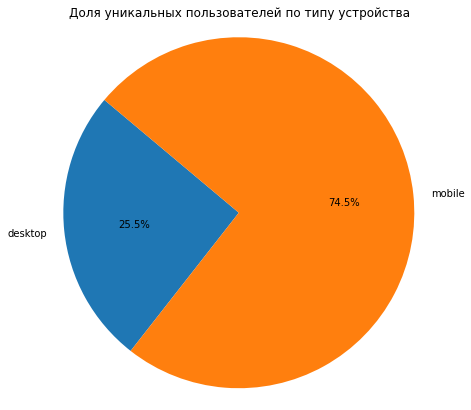

In [41]:
# Подсчитаем уникальных пользователей по типу устройства
unique_users =df_autumn.groupby('device_type_canonical')['user_id'].nunique()

display(unique_users)

# Визуализируем круговой диаграммой
plt.figure(figsize=(7, 7))
plt.pie(unique_users, labels=unique_users.index, autopct='%1.1f%%', startangle=140)
plt.title('Доля уникальных пользователей по типу устройства')
plt.axis('equal') 
plt.show()

Уникальные пользователи по типам устройств распределены неравномерно: стационарные - 4868, мобильные - 14192. Проверим пересечение пользователей в группах.

In [42]:
# Уникальные пользователи по типу устройства
mobile_users = set(df_autumn[df_autumn['device_type_canonical'] == 'mobile']['user_id'].unique())
desktop_users = set(df_autumn[df_autumn['device_type_canonical'] == 'desktop']['user_id'].unique())

# Пересечение пользователей
common_users = mobile_users.intersection(desktop_users)

display(f'Количество пользователей, использующих и мобильные, и стационарные устройства: {len(common_users)}')


'Количество пользователей, использующих и мобильные, и стационарные устройства: 3249'

Количество пользователей, использующих и мобильные, и стационарные устройства: 3249. Это довольно таки большое число по сравнению с группой пользователей стационарными устройствами (4868). Пока оставим как есть, удалять не будем.

Далее нужно посмотреть на распределение двух ключевых показателей:

- Количество заказов на пользователя
- Время между заказами пользователей

Для этого:

- Посчитаем количество заказов на пользователя по типу устройства
- Визуализируем распределения с помощью boxplot (ящик с усами) для выявления выбросов

In [43]:
# Посчитаем количество заказов на пользователя
orders_per_user = df_autumn.groupby(['user_id', 'device_type_canonical']).agg(order_count=('order_id', 'count')).reset_index()

Text(0.5, 0, 'Тип устройства')

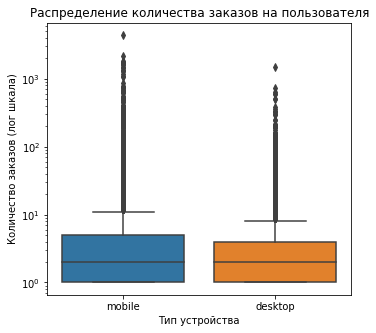

In [44]:
# Посчитаем количество заказов на пользователя
orders_per_user = df_autumn.groupby(['user_id', 'device_type_canonical']).agg(order_count=('order_id', 'count')).reset_index()

# Визуализируем распределение для количества заказов
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x='device_type_canonical', y='order_count', data=orders_per_user)
plt.title('Распределение количества заказов на пользователя')
plt.yscale('log')  # Логарифмическая шкала для удобства восприятия выбросов
plt.ylabel('Количество заказов (лог шкала)')
plt.xlabel('Тип устройства')

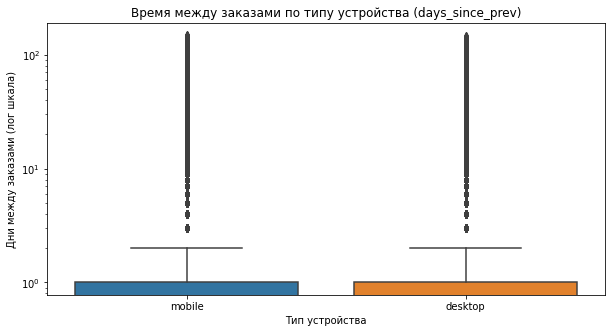

In [45]:
# Фильтруем данные, чтобы убрать нулевые или отрицательные значения по количеству дней между покупками пользователей
df_filtered = df_autumn[df_autumn['days_since_prev'] > 0]

# Визуализируем распрелеление для времени между заказами по типу устройства
plt.figure(figsize=(10, 5))
sns.boxplot(x='device_type_canonical', y='days_since_prev', data=df_autumn)
plt.title('Время между заказами по типу устройства (days_since_prev)')
plt.yscale('log')  # Логарифмическая шкала для лучшего отображения выбросов
plt.xlabel('Тип устройства')
plt.ylabel('Дни между заказами (лог шкала)')
plt.show()

Распределение двух ключевых показателей показывают, что в данных есть выбросы. Для проверки гипотез мы будем использовать непараметрический тест Манна-Уитни, так как данные распределены ненормально, в них имеются выбросы и разные размеры выборок в группах. 

Сформулируем гипотезы:

- 1.Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.
  - Нулевая гипотеза H₀: Среднее количество заказов на одного пользователя мобильного приложения не выше по сравнению с пользователями стационарных устройств.

  - Альтернативная гипотеза H₁:Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.
  
- 2.Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.
  - Нулевая гипотеза H₀: Среднее время между заказами пользователей мобильных приложений не выше по сравнению с пользователями стационарных устройств.

  - Альтернативная гипотеза H₁: Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.
  
Проверяем односторонние альтернативы, так как интересует именно "мобильные > стационарные".

In [46]:
# Гипотеза 1: сравнение количества заказов
mobile_orders = orders_per_user[orders_per_user['device_type_canonical'] == 'mobile']['order_count']
desktop_orders = orders_per_user[orders_per_user['device_type_canonical'] == 'desktop']['order_count']

# Тест Манна-Уитни (односторонний: mobile > desktop)
stat1, p_value1 = mannwhitneyu(mobile_orders, desktop_orders, alternative='greater')

display(f'Гипотеза 1 (количество заказов): статистика={stat1:.3f}, p-value={p_value1:.5f}')
if p_value1 < 0.05:
    display('Отвергаем нулевую гипотезу: у мобильных пользователей больше заказов.')
else:
    display('Нет оснований отвергать нулевую гипотезу: у мобильных пользователей не больше заказов.')

'Гипотеза 1 (количество заказов): статистика=36111903.000, p-value=0.00000'

'Отвергаем нулевую гипотезу: у мобильных пользователей больше заказов.'

In [47]:
# Гипотеза 2: сравнение времени между заказами
# Подготовка выборок для теста Манна-Уитни
mobile_times = df_filtered[df_filtered['device_type_canonical'] == 'mobile']['days_since_prev']
desktop_times = df_filtered[df_filtered['device_type_canonical'] == 'desktop']['days_since_prev']

# Тест Манна-Уитни (односторонний: mobile > desktop)
stat, p_value = mannwhitneyu(mobile_times, desktop_times, alternative='greater')

display(f'Гипотеза 2 (время между заказами): статистика={stat:.3f}, p-value={p_value:.5f}')
if p_value < 0.05:
    display('Отвергаем нулевую гипотезу: время между заказами у мобильных пользователей больше.')
else:
    display('Нет оснований отвергать нулевую гипотезу: время между заказами у мобильных пользователей не больше')


'Гипотеза 2 (время между заказами): статистика=165018955.500, p-value=0.18474'

'Нет оснований отвергать нулевую гипотезу: время между заказами у мобильных пользователей не больше'



**Выводы по исследованию активности пользователей мобильных и стационарных устройств**

Гипотеза 1: Среднее количество заказов на пользователя

- Результат: 
 - Статистика теста Манна-Уитни = 36111658.500 
 - p-value ≈ 0.00000 (очень маленькое значение) 
 
 Поскольку p-value значительно меньше уровня значимости 0.05, мы отвергаем нулевую гипотезу. Пользователи мобильных устройств в среднем делают больше заказов, что может свидетельствовать о большей активности или удобстве использования мобильного приложения.

---

2. Гипотеза 2: Среднее время между заказами

- Результат: 
 - Статистика теста = 165018955.500 
 - p-value = 0.18474 (больше 0.05) 

 Поскольку p-value больше 0.05, у нас нет статистических оснований отвергать нулевую гипотезу. Время между заказами у пользователей мобильных и стационарных устройств не отличается статистически значимо, то есть частота повторных заказов у обеих групп примерно сопоставима.


## Общий вывод и рекомендации

В данной исследовательской работе были сделаны следующие задачи и выводы:

**1. Загрузка данных и знакомство с ними** 

Нам предоставили для исследовани три датасета.Первый датасет **final_tickets_orders_df.csv** включает информацию обо всех заказах билетов, совершённых с двух типов устройств — мобильных и стационарных. В таблице представлены данные в 290849 строк и 14 столбцов. Названия столбцов в едином регистре, без лишних пробелов. Только в одном столбце days_since_prev есть пропуски и это нормально, они означают, что у этого покупателя не было покупок. В двух столбцах created_dt_msk и created_ts_msk не соответствут тип данных.

Второй датасет **final_tickets_events_df.csv** содержит информацию о событиях, включая город и регион события, а также информацию о площадке проведения мероприятия. В таблице представлены данные в 22427 строк и 11 столбцов. Названия столбцов в едином регистре, без лишних пробелов. Пропуски в данных отсутствуют, типы данных соответствуют описанию.

Третий датасет **final_tickets_tenge_df.csv** с информацией о курсе тенге к российскому рублю за 2024 год. Значения в рублях представлено для 100 тенге.В таблице представлены данные в 357 строк и 4 столбцов. Названия столбцов в едином регистре, без лишних пробелов. Пропуски в данных отсутствуют

**2. Предобработка данных и подготовка их к исследованию**
- Проверили данные на пропуски. Проверили, что выгрузка данных из SQL была успешной. Кроме столбца days_since_prev, данные не содержат пропусков.
- Изучили значения в ключевых столбцах и не обнаружили ошибок.
- Для категориальных значений изучили, какие категории присутствуют в данных.
- Для количественных значений посмотрели на распределение и наличие выбросов. Отобрали значения по 99-му процентилю.
- Проверили явные и неявные дубликаты. Явных не обнаружили, удалили 31 неявных.
- Провели преобразования типов данных в столбцах с датой и временем.
- Создали несколько новых столбцов:
  - revenue_rub — выручка с заказов в единой валюте (руб).
  - one_ticket_revenue_rub — выручка с продажи одного билета на мероприятие.
  - month — месяц оформления заказа.
  - season — информация о сезонности (лето,осень).  И по графику и по таблице убедились, что действительно наблюдается рост заказов к осени почти в 3 раза. Значит, сезонность имеет место быть.

**3. Исследовательский анализ данных**
- Провели анализ распределения заказов по сегментам и их сезонные изменения. Летом концерты чаще посещают, чем осенью. А вот к осени более популярно посещать театры и спортивные мероприятия. 
- По распределению заказов по типам устройств можно сказать, что сильного различия нет. Мобильные устройства лидируют и летом и осенью, летом чуть больше, т к многие в отпусках и больше времени проводят вне помещений, где могут быть использованы стационарные устройства. А вот осенью наоборот,больше заказов со стационарных устройств, т к больше времени проводят на работе, в помещениях.
- Самый популярный возраст, который посещают мероприятия это 16+, 12+ и 0+. В летний период более активны 16+, 12+,6+.  А осенью лидируют 16+,0+,12+. 
- Средняя выручка с одного билета по выставкам и стендапам выросла примерно на 5%, по категории спорт и другое снизилась на 2%, концерты, елки и театры подешевели более 10%. Число заказов по дням имеет положительную динамику, наблюдаются пики 1.09.2024 и 1.10.2024, видимо связанные с праздничным днем.
- Число активных пользователей также показывает рост. Среднее число заказов на пользователя стабильна, за исключением также 1.09.2024 и 1.10.2024, предполагаем, что из-за праздников.
- Средняя стоимость одного билета также более-менее стабильна, к концу осени наблюдается спад. Также видим резкое снижение 1.09.2024 и 1.10.2024, возможно из-за праздников проводились различные акции, что удешевило стоимость билета.
- По дням недели среднее количество заказов распределяется более-менее стабильно, резких скачков не наблюдается. Во вторник видим увеличение заказов, в воскресенье и понедельник меньше заказов, чем в другие дни недели.  
- Явным лидером по количеству уникальных мероприятий является Каменевский регион (5935), он занимает 27% из проводимых мероприятий и 31% по обработанным заказам. На второй позиции Североярская область (3800), он занимает 17% из проводимых мероприятий и 15% по заказам.За ними существенно отстает Широковская область (1232), он занимает 6% из проводимых мероприятий и 7% по заказам. 
- Явным лидером по количеству заказов является организатор "Билеты без проблем"	(62858), что составляет 2% от числа всех заказов, а по доле выручки от общей он составляет 1.6%. Вторую строчку занимает партнер "Лови билет!"	(40802), что составляет 1.4% от числа всех заказов, а по доле выручки от общей он составляет 1.1%. Третью позицию занимает организатор "Билеты в руки" (40281)	,что составляет 1.3% от числа всех заказов, а по доле выручки от общей он составляет уже 0.8%.
**4. Статистический анализ данных**
По исследованию активности пользователей мобильных и стационарных устройств сделали следующие выводы:
- Гипотеза 1: Среднее количество заказов на пользователя

Результат:

Статистика теста Манна-Уитни = 36111658.500
p-value ≈ 0.00000 (очень маленькое значение)
Поскольку p-value значительно меньше уровня значимости 0.05, мы отвергаем нулевую гипотезу. Пользователи мобильных устройств в среднем делают больше заказов, что может свидетельствовать о большей активности или удобстве использования мобильного приложения.

- Гипотеза 2: Среднее время между заказами
Результат:

Статистика теста = 165018955.500
p-value = 0.18474 (больше 0.05)
Поскольку p-value больше 0.05, у нас нет статистических оснований отвергать нулевую гипотезу. Время между заказами у пользователей мобильных и стационарных устройств не отличается статистически значимо, то есть частота повторных заказов у обеих групп примерно сопоставима.


**Общий итог**

По поставленной задаче выяснить причину почему к осени наблюдается спад средней выручки при росте заказов был сделан вывод, что осенью больше проводятся мероприятий посвященных праздникам и возможно из-за проведенных акций снизилась и выручка. Также одной из причин может быть то, что летом более популярны концерты, а стоимость билета на концерты существенно дороже, чем на остальные мероприятия. 

По проверке гипотез мы выяснили, что мобильные пользователи более активны в плане общего количества заказов. Однако периодичность или интервал между заказами не различается между мобильными и стационарными пользователями. Это может говорить о том, что мобильные пользователи совершают больше заказов, но с примерно такой же частотой, как и стационарные пользователи.

**Рекомендации**

Сезонная оптимизация ценовой политики:
- Внедрить динамическое ценообразование в зависимости от типа мероприятия и сезона
- Разработать премиальные пакеты билетов для праздничных мероприятий осенью
- Создать специальные предложения для концертов в низкий сезон

Работа с мобильными пользователями:
- Разработать специальные акции для мобильных пользователей
- Внедрить push-уведомления о премиальных мероприятиях и высоких ценах

Продуктовые рекомендации:
- Увеличить долю концертов и других высокомаржинальных мероприятий осенью
- Разработать гибридные форматы мероприятий, сочетающие разные типы развлечений
- Внедрить систему персонализированных рекомендаций на основе предпочтений пользователя

Маркетинговые активности:
- Проводить точечные акции на высокомаржинальные мероприятия
- Разработать стратегию продвижения концертов и других дорогих мероприятий
- Внедрить "допродажи" сопутствующих услуг

